##### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# fix random seed for reproducibility
np.random.seed(7)

# Notebook

The folder time_series contains a list of files. Each file contains all the time series associated with a given product. Each time series corresponds to a company.

There are two types of files:

**- Wide**: each column corresponds to the time series of a company.

**- Long**: the information is stored in long format. The column company identifies the company, the colum timestamp the instant at which a price was recorded, and the column price the value of the price. These dataframes contain some other columns whose meaning will be explained next.

On the title of each file the Product Group (a product group corresponds to a group of time series of the same product sold by different companies) is identified by a number, called the product_group_id.

The file 'product_information' contains information about the products in each product group. This file contains the following columns:

- **offer_type** - offer type associated with that time series. A product can be locked, unlocked... to a certain operator.
- **product** - name of the product associated with time series
- **product_group_id** - uniquely identifies a product group. A product group is uniquely identified by its name and its offer_type.

**Example**: read a file and its product_information

In [2]:
# Select product_group_id
product_group_id = 958
# Read file
df = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [3]:
# Read product information of the time series of that product group
product_information = pd.read_pickle("Data/product_information")
product_information

,product,offer_type
product_group_id,,
1,xiaomi Pocophone 128GB,unlocked
2,xiaomi Redmi Note 8 128GB,unlocked
5,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 6,unlocked
6,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 8,unlocked
7,blu Joy Adulto Mayor Sos,unlocked
...,...,...
952,huawei P30 128GB + P Smart 2019,unlocked
953,motorola Moto G7 Power 64GB,unlocked
956,nokia 6.1 32GB,unlocked


In [4]:
def get_product_wide(product_group_id, time_series='1'):
    return pd.read_pickle(f"Data/time_series_{time_series}/wide_product_group_id_{product_group_id}")

# Data Visualization

In [5]:
plt.rcParams['figure.dpi'] = 100
product_group_id = 958
time_series = '1'

df_wide = get_product_wide(product_group_id, time_series=time_series)
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
print("Number of daily data: ", len(df_wide))

Number of daily data:  507


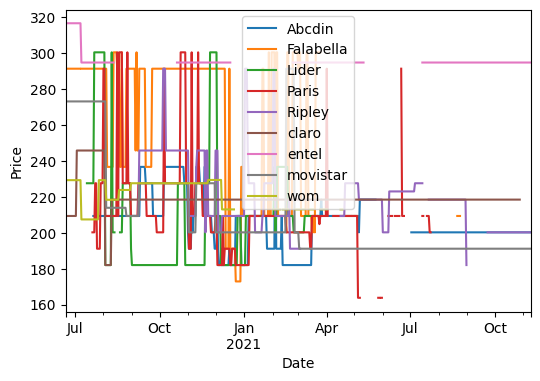

In [6]:
df_wide.plot()
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

Reduced the number of days so more companies have relevant data

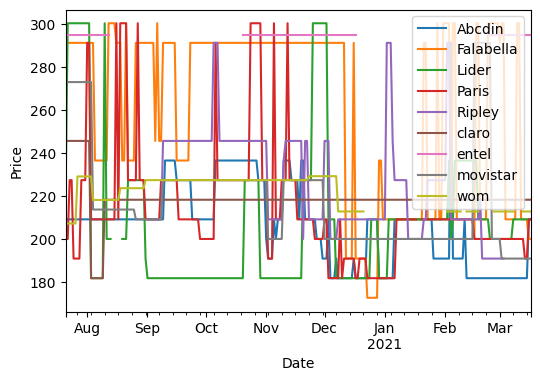

In [7]:
df_wide = df_wide[30:270]
df_wide.plot()
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

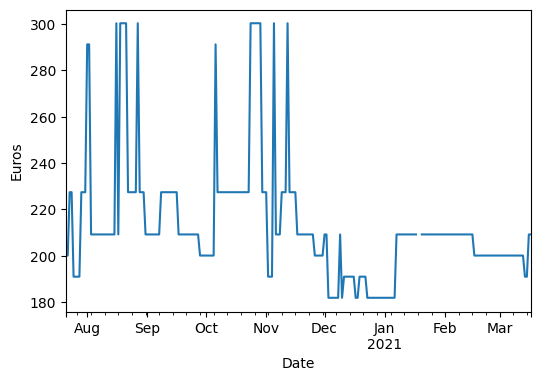

In [8]:
df_wide["Paris"].plot()
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

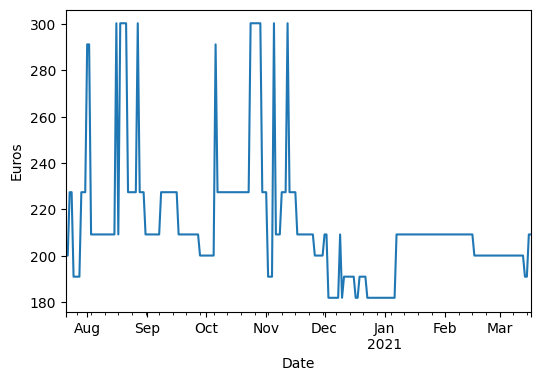

In [9]:
df_wide["Paris"].fillna(method='bfill', inplace=True)
df_wide["Paris"].fillna(method='ffill', inplace=True)
df_wide["Paris"].plot()
# plt.title(f"Paris's price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

Abcdin 240
Falabella 240
Lider 240
Paris 240
Ripley 240
claro 240
entel 240
movistar 240
wom 240


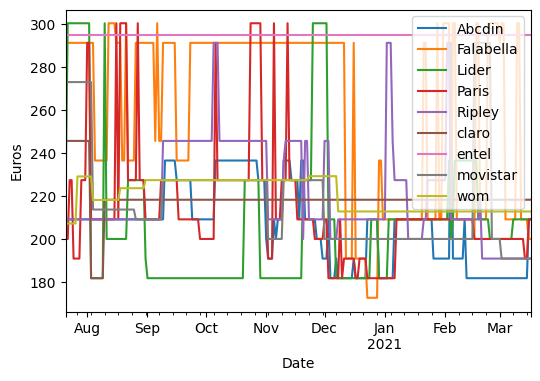

In [10]:
for comp in df_wide.keys():
    df_wide[comp].fillna(method='ffill', inplace=True)
    df_wide[comp].fillna(method='bfill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
# plt.title(f"Companies price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

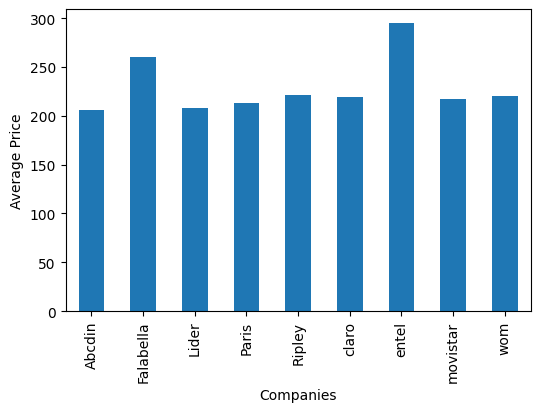

In [11]:
plt.ylabel("Average Price")
plt.xlabel("Companies")
df_wide.mean().plot(kind='bar')
plt.show()

## Signal Decomposition

### Multiplicative Model

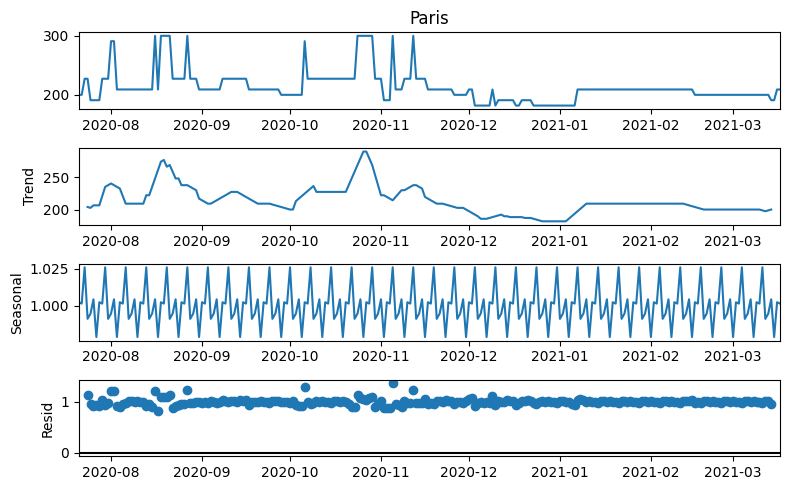

In [12]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
components = seasonal_decompose(df_wide["Paris"], model='multiplicative', period=7)
components.plot()
plt.show()

### Additive Model

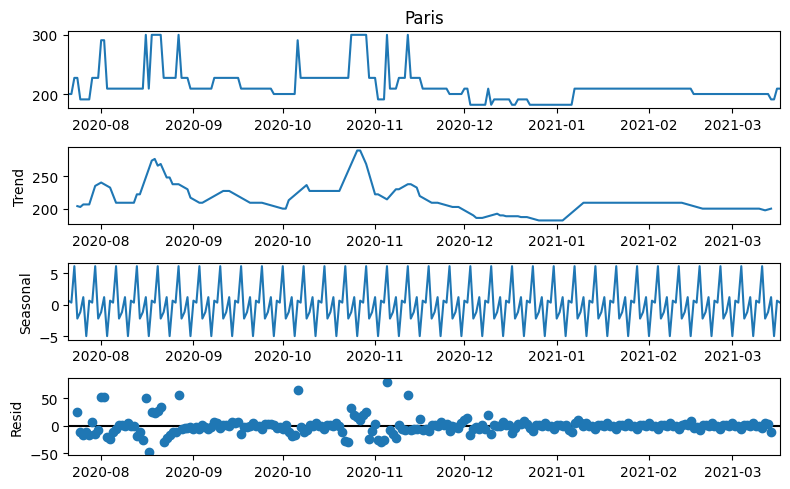

In [13]:
components = seasonal_decompose(df_wide["Paris"], model='additive', period=7)
components.plot()
plt.show()

In [14]:
product_group_id = 958
time_series = '1'
company = "Paris"
n_steps = 8 # number of days
train_split_amount = 0.7

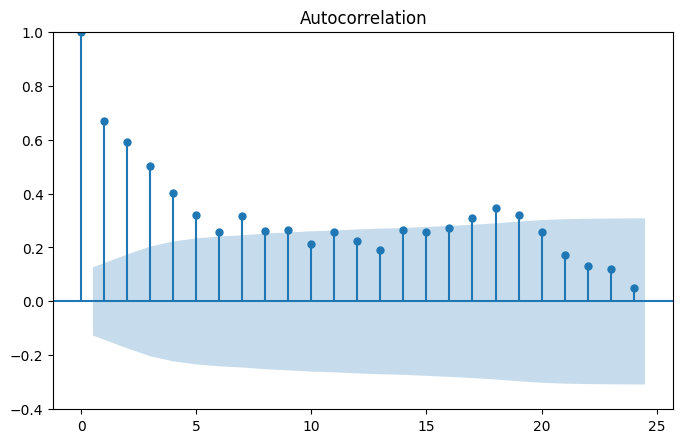

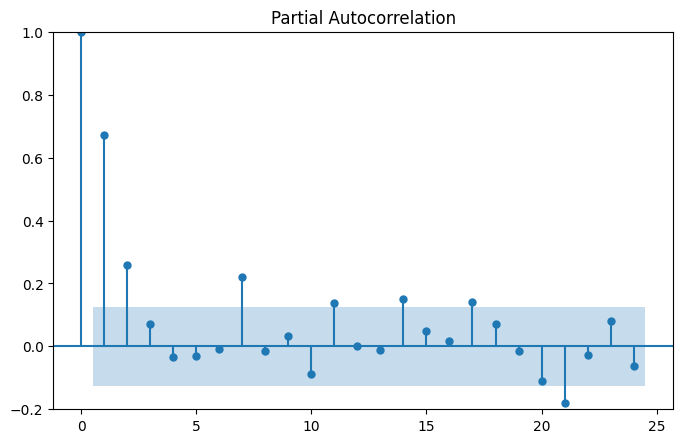

In [15]:
plot_acf(df_wide[company])
plt.ylim(-0.4)
plot_pacf(df_wide[company])
plt.ylim(-0.2)
plt.show()

In [16]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_wide[company])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.6211914137014696
p-value: 0.08869604938237008


Since the p-value is higher than 0.05 we don't reject the null hypothesis with a high probability, meaning that data is not stationary.

# Define Evaluation metrics

In [17]:
product_group_id = 958
time_series = '1'
company = "Paris"
n_steps = 8 # number of days
train_split_amount = 0.7

def evaluate_pred(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = str(round(np.sqrt(mse), 4))
    rmsle = str(round(np.log(np.sqrt(mse)), 4))
    mse = str(round(mse, 4))
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adjusted_r2 = str(round(1 - ((1-r2) * ((n-1)/(n-k-1))), 4))
    r2 = str(round(r2, 4))

    table = [
        ["Mean Absolute Error (MAE)", mae],
        ["Mean Squared Error (MSE)", mse],
        ["Root Mean Squared Error (RMSE)", rmse],
        ["Root Mean Squared Log Error (RMSLE)", rmsle],
        ["R Squared (R2)", r2],
        ["Adjusted R Squared (AR2)", adjusted_r2],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    fig = plt.figure(figsize=(8, 4), dpi=100)
    plt.plot(y_test, color='b', label='real data')
    plt.plot(y_pred, color='r', label='predictions on test data')
    plt.title("Product Price Prediction")
    plt.xlabel('samples')
    plt.legend()
    plt.show()

    return [x[1] for x in table]

# Define Evaluation Strategy

In [18]:
n_epochs = 50
verbose = 0

# define evaluation strategy
def train_and_test_model(model, n_epochs=50, verbose=0):
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=n_epochs, verbose=verbose)

    # get predictions on test data
    y_pred = model.predict(X_test, verbose=verbose)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss function')
    plt.legend(['train', 'test'])
    plt.xlabel('iterations')

    return y_pred

# Univariate Models

## Get Train and Test Data

In [19]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

df_wide = get_product_wide(product_group_id, time_series)[30:270]
if company in df_wide.keys():
    # DROP NAN VALUES
    df_wide[company].fillna(method='bfill', inplace=True)
    df_wide[company].fillna(method='ffill', inplace=True)
    prices = df_wide[company].values

    # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
    X, y = split_sequence(prices, n_steps)

    # SPLIT INTO TRAIN AND TEST DATA
    train_size = int(len(y) * train_split_amount)
    test_size = len(y) - train_size

    # ADD DATA TO DATASET
    X_train = np.concatenate((X_train, X[0:train_size,:]))
    y_train = np.append(y_train, y[0:train_size])
    X_test = np.concatenate((X_test, X[train_size:,:]))
    y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(162, 8)
(162,)
(70, 8)
(70,)


## Normalizing Data

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [21]:
# We are working with a univariate series, so the number of features is one, for one variable.
n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_train.shape)
print(X_test.shape)

univariate_results = []

(162, 8, 1)
(70, 8, 1)


## ARIMA

### Making data stationary

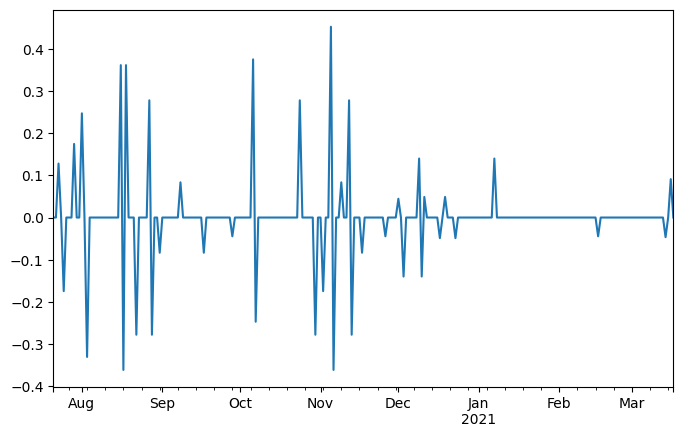

In [22]:
# Take the log difference to make data stationary
df_wide_stat = np.log(df_wide[company])
df_wide_stat = df_wide_stat.diff().fillna(0)
df_wide_stat.plot()
plt.show()

In [23]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_wide_stat)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.370729399585583
p-value: 2.3486718165107305e-08


P-value less than 0.05 which means we reject the null hypothesis and data is now stationary.

In [24]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try:
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
    
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [25]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df_wide_stat[:train_size])

result_df

100%|██████████| 64/64 [00:16<00:00,  3.82it/s]


,"(p, d, q)",AIC
0,"(0, 1, 6)",-281.335102
1,"(0, 1, 7)",-279.912039
2,"(6, 1, 1)",-279.851153
3,"(0, 1, 5)",-279.756440
4,"(2, 1, 7)",-279.127959
...,...,...
59,"(5, 1, 0)",-234.445174
60,"(3, 1, 0)",-230.458475
61,"(2, 1, 0)",-215.825831
62,"(1, 1, 0)",-179.747756


In [26]:
best_order = result_df[result_df.AIC == result_df.AIC.min()]["(p, d, q)"].values[0]
best_order

(0, 1, 6)

                               SARIMAX Results                                
Dep. Variable:                  Paris   No. Observations:                  162
Model:               SARIMAX(0, 1, 6)   Log Likelihood                 147.668
Date:                Thu, 19 Jan 2023   AIC                           -281.335
Time:                        23:19:40   BIC                           -259.765
Sample:                    07-21-2020   HQIC                          -272.577
                         - 12-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5118      0.072    -21.133      0.000      -1.652      -1.372
ma.L2          0.5473      0.099      5.546      0.000       0.354       0.741
ma.L3         -0.0736      0.129     -0.570      0.5

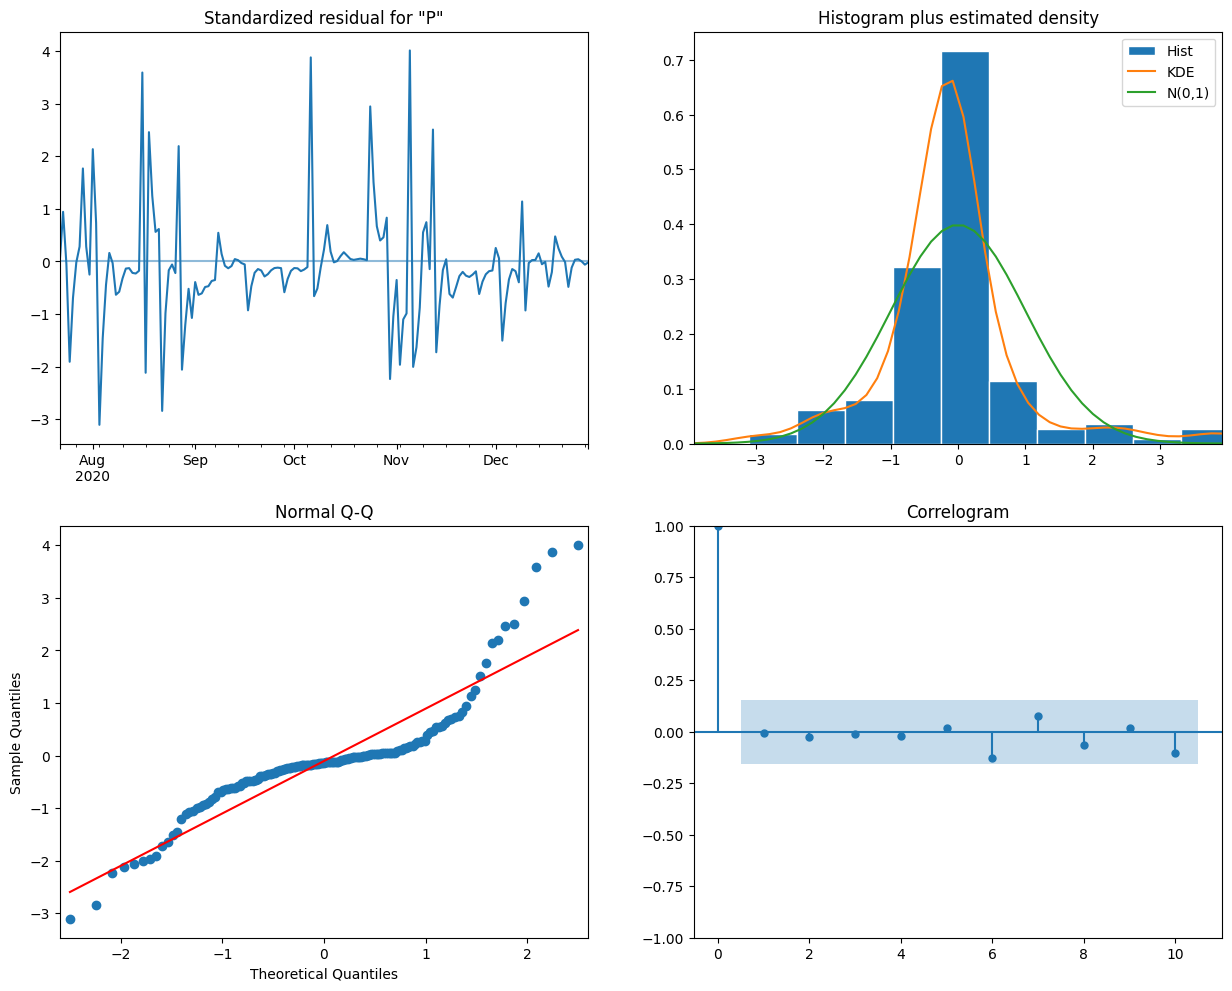

In [27]:
best_model = SARIMAX(df_wide_stat[:train_size], order=best_order).fit()
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [28]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide_stat) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 78 next values
2020-12-30   -0.002749
2020-12-31   -0.003158
2021-01-01   -0.002155
2021-01-02   -0.001553
2021-01-03   -0.002374
                ...   
2021-03-13   -0.002676
2021-03-14   -0.002676
2021-03-15   -0.002676
2021-03-16   -0.002676
2021-03-17   -0.002676
Freq: D, Name: predicted_mean, Length: 78, dtype: float64
Statistics of confidence intervals


Paris,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-12-30,-0.002749,0.094539,-0.188043,0.182545
2020-12-31,-0.003158,0.106200,-0.211306,0.204991
2021-01-01,-0.002155,0.106253,-0.210407,0.206097
2021-01-02,-0.001553,0.106314,-0.209925,0.206818
2021-01-03,-0.002374,0.106565,-0.211237,0.206489
...,...,...,...,...
2021-03-13,-0.002676,0.107726,-0.213815,0.208463
2021-03-14,-0.002676,0.107727,-0.213816,0.208465
2021-03-15,-0.002676,0.107727,-0.213818,0.208466
2021-03-16,-0.002676,0.107728,-0.213819,0.208468



Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             7.0872
Mean Squared Error (MSE)             81.2856
Root Mean Squared Error (RMSE)        9.0159
Root Mean Squared Log Error (RMSLE)   2.199
R Squared (R2)                       -0.1167
Adjusted R Squared (AR2)             -0.2631


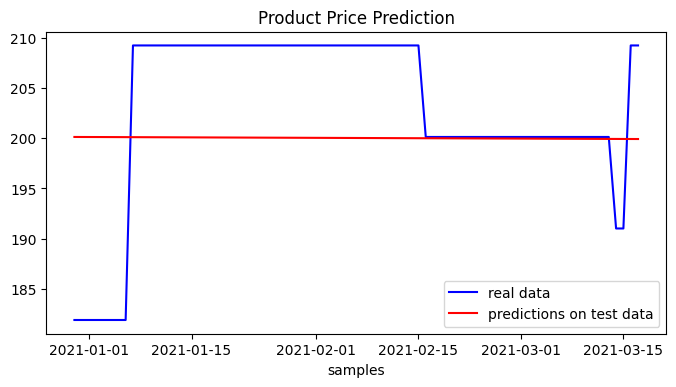

In [29]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
y_pred.iloc[0] = df_wide[company].iloc[0]
y_pred = y_pred.cumsum()
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "ARIMA")
univariate_results.append(metrics)

## SARIMA

In [30]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
        results.append([param, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [31]:
## SARIMA grid of hyperparameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7 # a season was considered to be a week

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, d, D, s, df_wide_stat[:train_size])
result_df

256


100%|██████████| 256/256 [03:08<00:00,  1.36it/s]


,"(p,q)x(P,Q)",AIC
0,"(1, 2, 0, 1)",-242.364813
1,"(0, 2, 0, 1)",-241.807471
2,"(1, 2, 1, 1)",-241.650477
3,"(1, 2, 0, 2)",-241.430265
4,"(1, 2, 0, 3)",-241.073571
...,...,...
251,"(0, 0, 0, 1)",-76.817945
252,"(0, 0, 3, 0)",-63.548933
253,"(0, 0, 2, 0)",-52.561047
254,"(0, 0, 1, 0)",-51.518282


In [32]:
# Choose the values that minimize the AIC score
best_values = result_df[result_df.AIC == result_df.AIC.min()]["(p,q)x(P,Q)"].values[0]
best_order = (best_values[0], d, best_values[1])
print(best_order)
best_seasonal_order = (best_values[2], D, best_values[3], s)
print(best_seasonal_order)

(1, 1, 2)
(0, 1, 1, 7)


                                      SARIMAX Results                                      
Dep. Variable:                               Paris   No. Observations:                  162
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood                 126.182
Date:                             Thu, 19 Jan 2023   AIC                           -242.365
Time:                                     23:22:49   BIC                           -227.180
Sample:                                 07-21-2020   HQIC                          -236.197
                                      - 12-29-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4743      0.098      4.832      0.000       0.282       0.667
ma.L1         -1.8771      

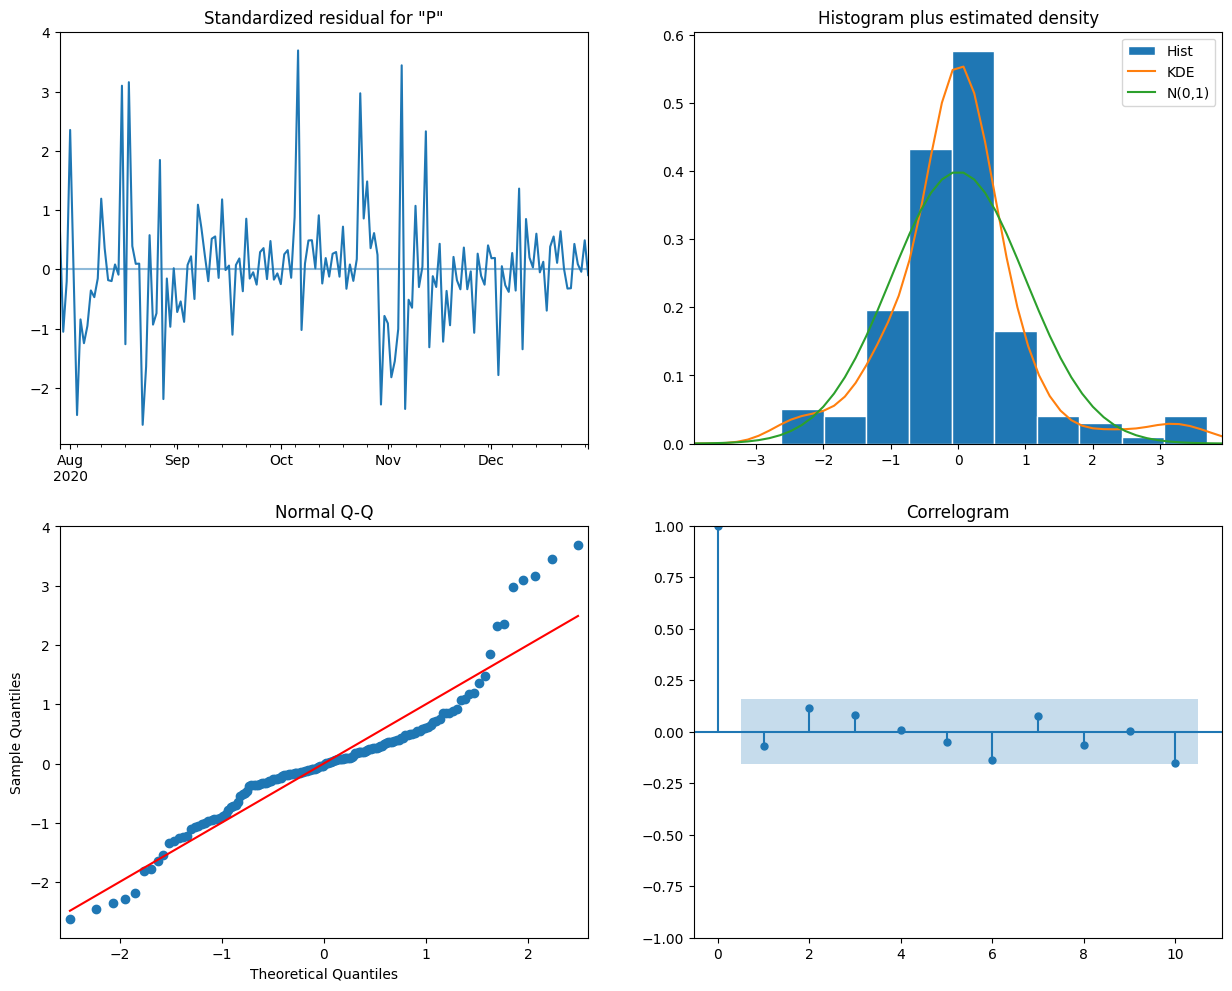

In [33]:
best_model = SARIMAX(df_wide_stat[:train_size], order=best_order, seasonal_order=best_seasonal_order).fit(dis=-1)
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [34]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 78 next values
2020-12-30   -0.009391
2020-12-31    0.022303
2021-01-01   -0.055597
2021-01-02    0.000127
2021-01-03    0.010847
                ...   
2021-03-13   -0.003066
2021-03-14    0.007349
2021-03-15   -0.047954
2021-03-16    0.024019
2021-03-17   -0.008110
Freq: D, Name: predicted_mean, Length: 78, dtype: float64
Statistics of confidence intervals


Paris,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-12-30,-0.009391,0.098159,-0.201778,0.182997
2020-12-31,0.022303,0.105249,-0.183980,0.228587
2021-01-01,-0.055597,0.106733,-0.264791,0.153596
2021-01-02,0.000127,0.107041,-0.209670,0.209923
2021-01-03,0.010847,0.107094,-0.199054,0.220747
...,...,...,...,...
2021-03-13,-0.003066,0.107230,-0.213234,0.207101
2021-03-14,0.007349,0.107220,-0.202798,0.217497
2021-03-15,-0.047954,0.107194,-0.258050,0.162142
2021-03-16,0.024019,0.107151,-0.185993,0.234031



Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             7.23
Mean Squared Error (MSE)             82.3038
Root Mean Squared Error (RMSE)        9.0721
Root Mean Squared Log Error (RMSLE)   2.2052
R Squared (R2)                       -0.1306
Adjusted R Squared (AR2)             -0.2789


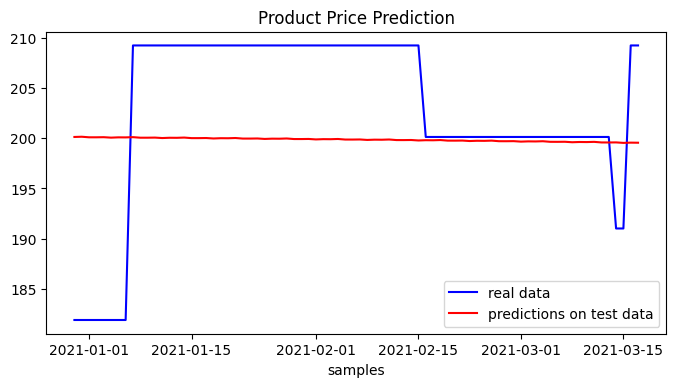

In [35]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
y_pred.iloc[0] = df_wide[company].iloc[0]
y_pred = y_pred.cumsum()
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "SARIMA")
univariate_results.append(metrics)

## Vanilla LSTM

In [36]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


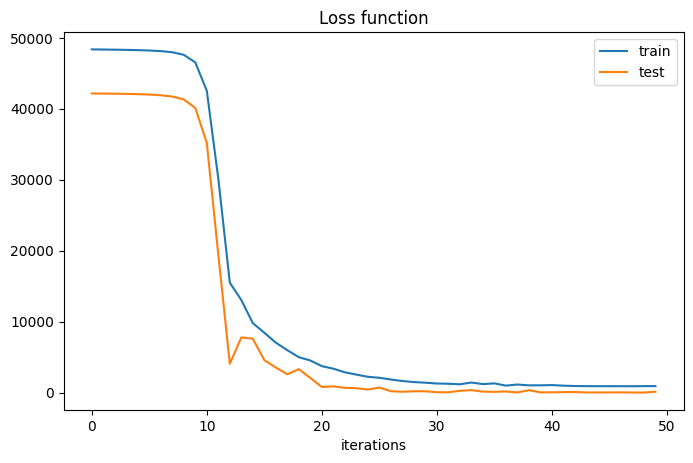

In [37]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             11.1596
Mean Squared Error (MSE)             150.195
Root Mean Squared Error (RMSE)        12.2554
Root Mean Squared Log Error (RMSLE)    2.506
R Squared (R2)                        -5.0093
Adjusted R Squared (AR2)              -5.7974


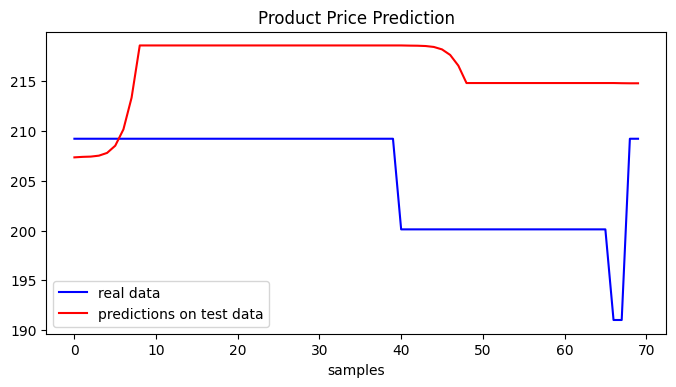

In [38]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
univariate_results.append(metrics)

## Stacked LSTM

In [39]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8, 50)             10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


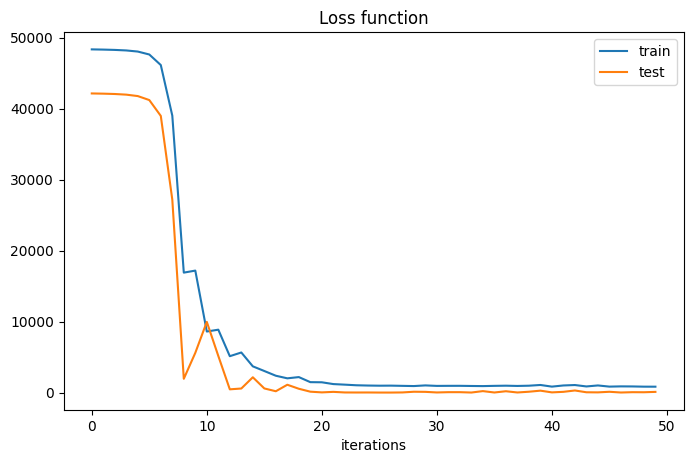

In [40]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.6093
Mean Squared Error (MSE)             126.267
Root Mean Squared Error (RMSE)        11.2368
Root Mean Squared Log Error (RMSLE)    2.4192
R Squared (R2)                        -4.0519
Adjusted R Squared (AR2)              -4.7145


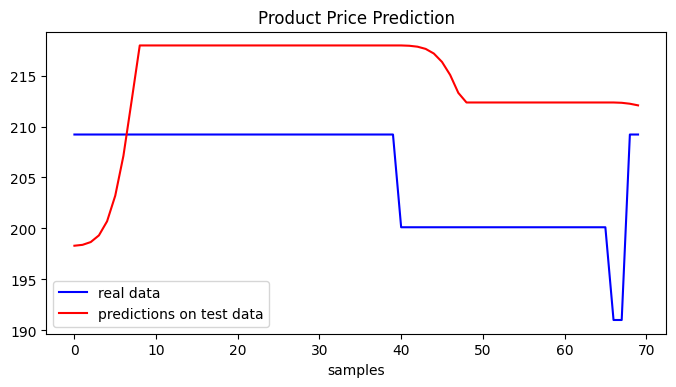

In [41]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
univariate_results.append(metrics)

## Bidirectional LSTM

In [42]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

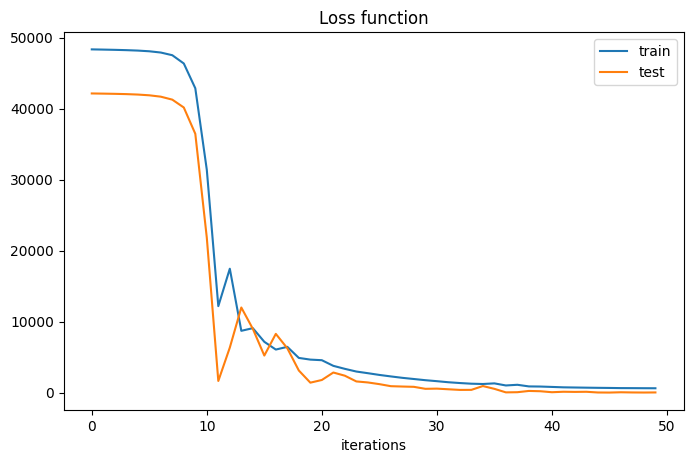

In [43]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             5.1981
Mean Squared Error (MSE)             47.0205
Root Mean Squared Error (RMSE)        6.8572
Root Mean Squared Log Error (RMSLE)   1.9253
R Squared (R2)                       -0.8813
Adjusted R Squared (AR2)             -1.128


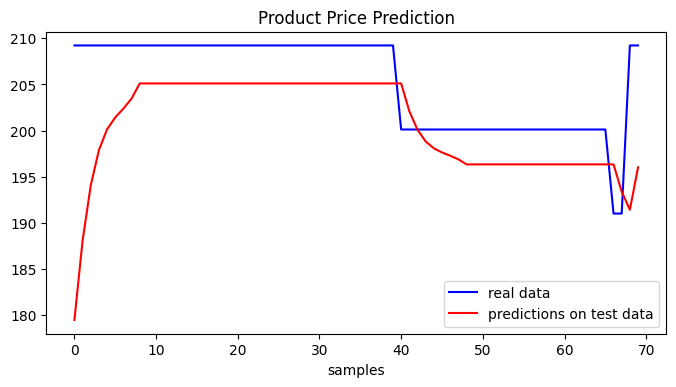

In [44]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
univariate_results.append(metrics)

## CNN LSTM

In [45]:
# reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)


(162, 2, 4, 1)
(70, 2, 4, 1)


In [46]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

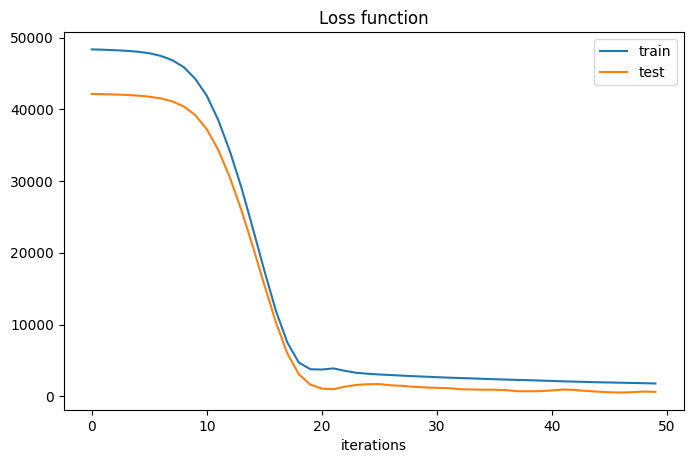

In [47]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             22.4294
Mean Squared Error (MSE)             614.691
Root Mean Squared Error (RMSE)        24.793
Root Mean Squared Log Error (RMSLE)    3.2106
R Squared (R2)                       -23.5937
Adjusted R Squared (AR2)             -24.3278


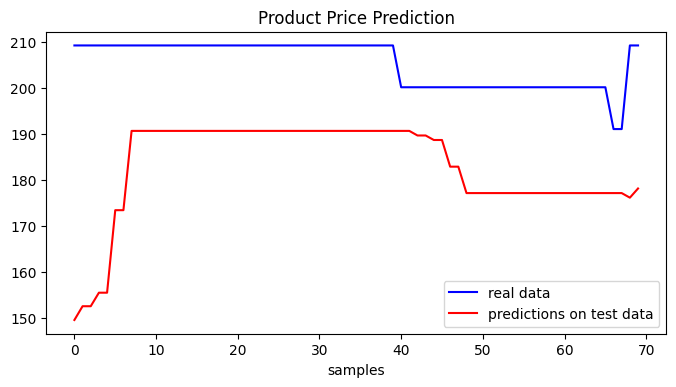

In [48]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
univariate_results.append(metrics)

## ConvLSTM

In [49]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)

(162, 2, 1, 4, 1)
(70, 2, 1, 4, 1)


In [50]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

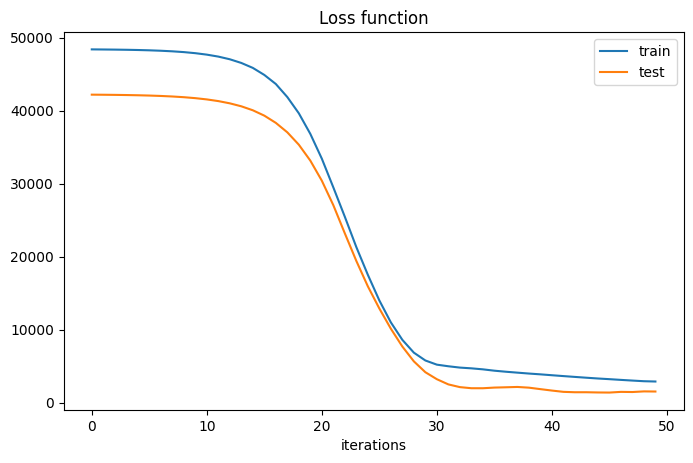

In [51]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              36.3383
Mean Squared Error (MSE)             1506.76
Root Mean Squared Error (RMSE)         38.817
Root Mean Squared Log Error (RMSLE)     3.6589
R Squared (R2)                        -59.2852
Adjusted R Squared (AR2)              -61.0848


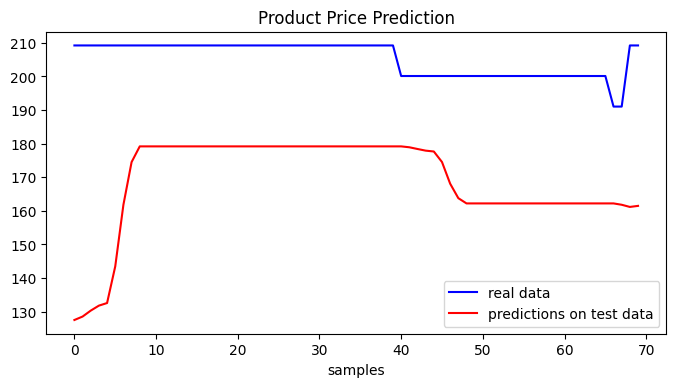

In [52]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
univariate_results.append(metrics)

## Models Results

In [53]:
print(tabulate(univariate_results,
               headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(univariate_results,
         headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )

\begin{tabular}{lrrrrrr}
\toprule
 Univariate Model   &     MAE &       MSE &    RMSE &   RMSLE &       R2 &      AR2 \\
\midrule
 ARIMA              &  7.0872 &   81.2856 &  9.0159 &  2.199  &  -0.1167 &  -0.2631 \\
 SARIMA             &  7.23   &   82.3038 &  9.0721 &  2.2052 &  -0.1306 &  -0.2789 \\
 Vanilla LSTM       & 11.1596 &  150.195  & 12.2554 &  2.506  &  -5.0093 &  -5.7974 \\
 Stacked LSTM       & 10.6093 &  126.267  & 11.2368 &  2.4192 &  -4.0519 &  -4.7145 \\
 Bidirectional LSTM &  5.1981 &   47.0205 &  6.8572 &  1.9253 &  -0.8813 &  -1.128  \\
 CNN LSTM           & 22.4294 &  614.691  & 24.793  &  3.2106 & -23.5937 & -24.3278 \\
 ConvLSTM           & 36.3383 & 1506.76   & 38.817  &  3.6589 & -59.2852 & -61.0848 \\
\bottomrule
\end{tabular}


Univariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
ARIMA,7.0872,81.2856,9.0159,2.199,-0.1167,-0.2631
SARIMA,7.23,82.3038,9.0721,2.2052,-0.1306,-0.2789
Vanilla LSTM,11.1596,150.195,12.2554,2.506,-5.0093,-5.7974
Stacked LSTM,10.6093,126.267,11.2368,2.4192,-4.0519,-4.7145
Bidirectional LSTM,5.1981,47.0205,6.8572,1.9253,-0.8813,-1.128
CNN LSTM,22.4294,614.691,24.793,3.2106,-23.5937,-24.3278
ConvLSTM,36.3383,1506.76,38.817,3.6589,-59.2852,-61.0848


# Multivariate Models

## Get Train and Test Data

Abcdin 240
Falabella 240
Lider 240
Paris 240
Ripley 240
claro 240
entel 240
movistar 240
wom 240


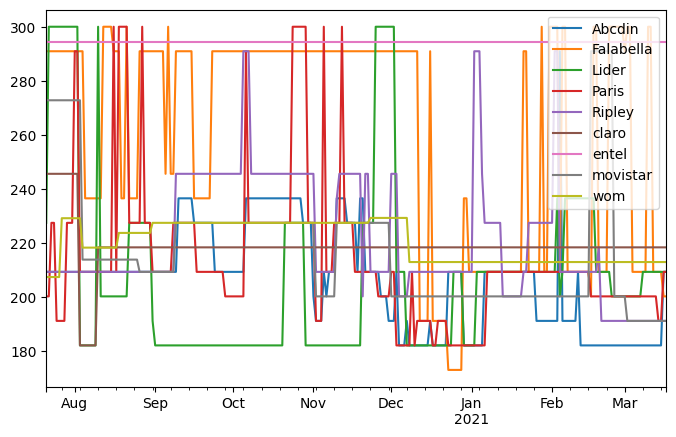

In [54]:
df_wide = get_product_wide(product_group_id, time_series)[30:270]
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
for comp in df_wide.keys():
    df_wide[comp].fillna(method='bfill', inplace=True)
    df_wide[comp].fillna(method='ffill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
n_days = len(df_wide)
n_companies = len(df_wide.keys())
company = "Paris"

In [55]:
X_train = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_train = np.empty(shape=[0], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_test = np.empty(shape=[0], dtype=np.float32)

X, y = list(), list()

# GET PRICES DATA OF THAT COMPANY
prices = df_wide[company].values

for i in range(n_days):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > n_days-1:
        break
    seq_x = []
    # gather input of the pattern from all companies
    for j in range(i, end_ix):
        temp_seq = []
        for comp in df_wide.keys():
            temp_seq.append(df_wide[comp].values[j])
        seq_x.append(temp_seq)
    # gather the output parts of the chosen company
    y.append(prices[end_ix])
    X.append(seq_x)

X, y = np.array(X), np.array(y)

# SPLIT INTO TRAIN AND TEST DATA
train_size = int(len(y) * train_split_amount)
test_size = len(y) - train_size

# ADD DATA TO DATASET
X_train = np.concatenate((X_train, X[0:train_size,:]))
y_train = np.append(y_train, y[0:train_size])
X_test = np.concatenate((X_test, X[train_size:,:]))
y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(162, 8, 9)
(162,)
(70, 8, 9)
(70,)


In [56]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)

(162, 72)
(70, 72)


## Normalize Features

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [58]:
X_train = X_train.reshape(X_train.shape[0], n_steps, n_companies)
X_test = X_test.reshape(X_test.shape[0], n_steps, n_companies)

print(X_train.shape)
print(X_test.shape)

(162, 8, 9)
(70, 8, 9)


In [59]:
multivariate_results = []

## Vanilla LSTM

In [60]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                12000     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


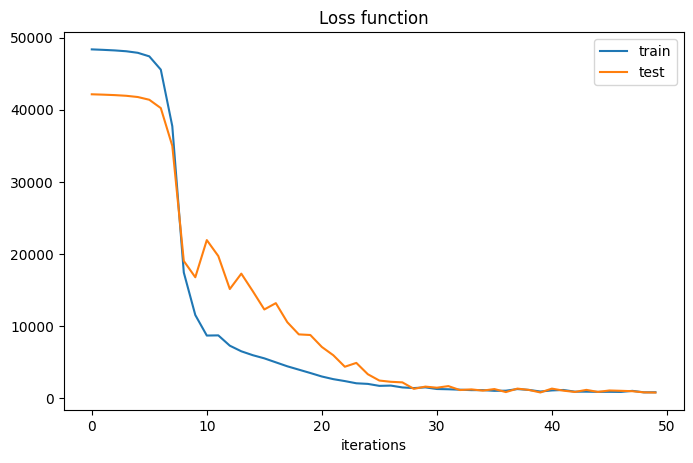

In [61]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             22.4376
Mean Squared Error (MSE)             812.556
Root Mean Squared Error (RMSE)        28.5054
Root Mean Squared Log Error (RMSLE)    3.3501
R Squared (R2)                       -31.5102
Adjusted R Squared (AR2)             -35.7739


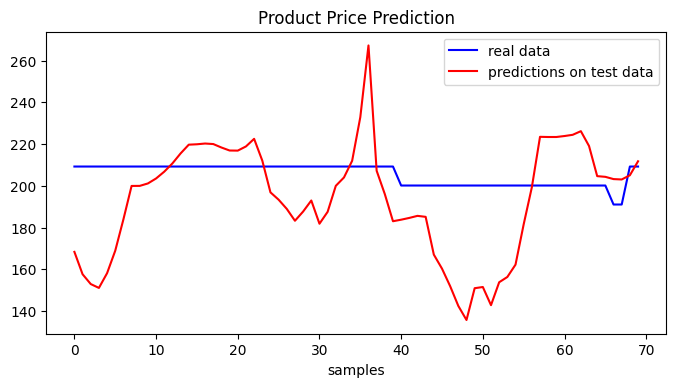

In [62]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
multivariate_results.append(metrics)

## Stacked LSTM

In [63]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_companies)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8, 50)             12000     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


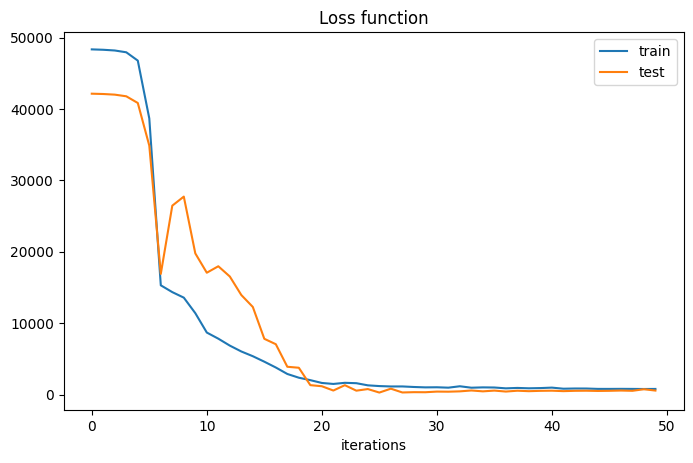

In [64]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             18.9358
Mean Squared Error (MSE)             571.144
Root Mean Squared Error (RMSE)        23.8986
Root Mean Squared Log Error (RMSLE)    3.1738
R Squared (R2)                       -21.8514
Adjusted R Squared (AR2)             -24.8483


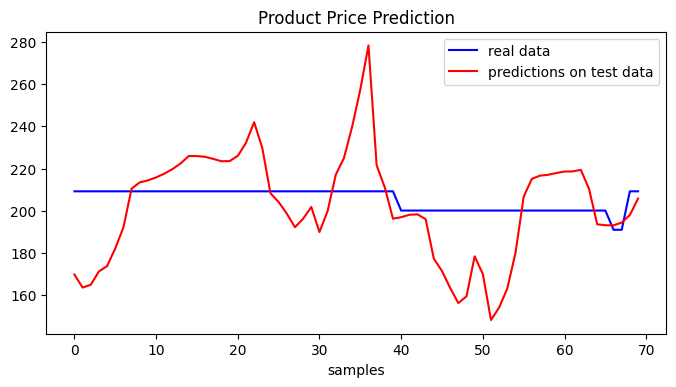

In [65]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
multivariate_results.append(metrics)

## Bidirectional LSTM

In [66]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

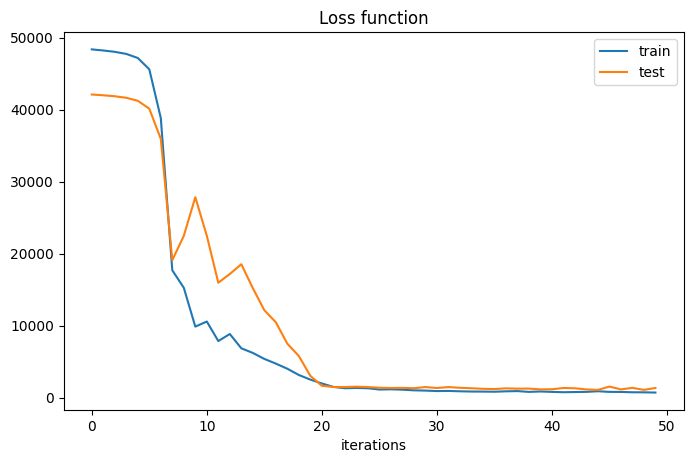

In [67]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              30.5841
Mean Squared Error (MSE)             1339.49
Root Mean Squared Error (RMSE)         36.5991
Root Mean Squared Log Error (RMSLE)     3.6
R Squared (R2)                        -52.5928
Adjusted R Squared (AR2)              -59.6214


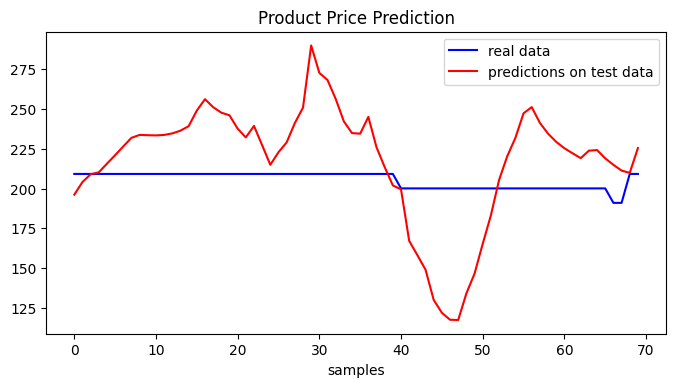

In [68]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
multivariate_results.append(metrics)

## CNN LSTM

In [69]:
# reshape from [samples, timesteps, companies] into [samples, subsequences, timesteps, companies]
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)


(162, 2, 4, 9)
(70, 2, 4, 9)


In [70]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_companies)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

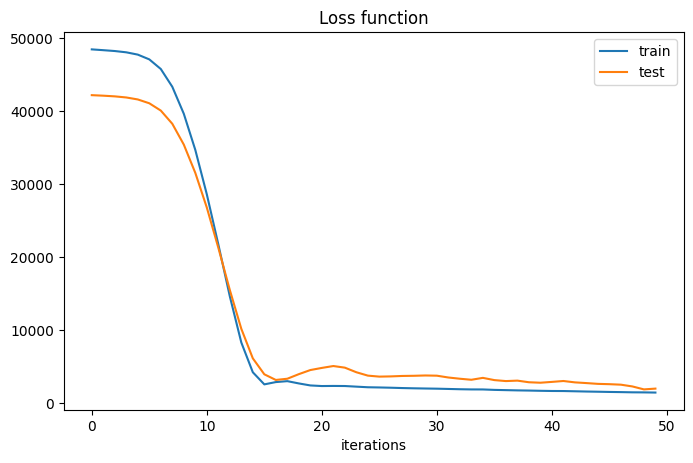

In [71]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              40.1356
Mean Squared Error (MSE)             1968.55
Root Mean Squared Error (RMSE)         44.3683
Root Mean Squared Log Error (RMSLE)     3.7925
R Squared (R2)                        -77.7614
Adjusted R Squared (AR2)              -80.1125


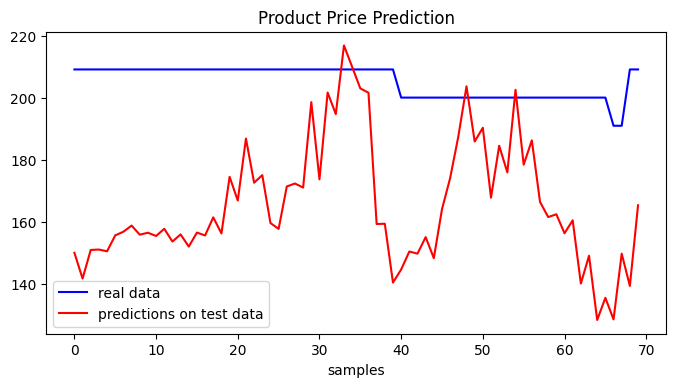

In [72]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
multivariate_results.append(metrics)

## ConvLSTM

In [73]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)

(162, 2, 1, 4, 9)
(70, 2, 1, 4, 9)


In [74]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_companies)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

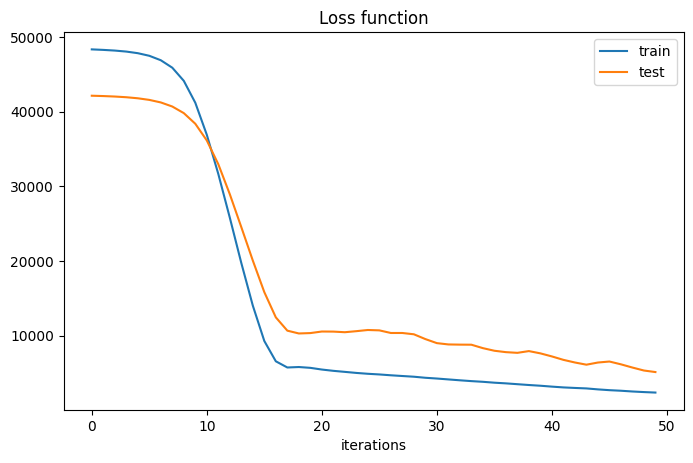

In [75]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                   Value
-----------------------------------  ---------
Mean Absolute Error (MAE)              69.8488
Mean Squared Error (MSE)             5145.45
Root Mean Squared Error (RMSE)         71.7318
Root Mean Squared Log Error (RMSLE)     4.2729
R Squared (R2)                       -204.869
Adjusted R Squared (AR2)             -211.014


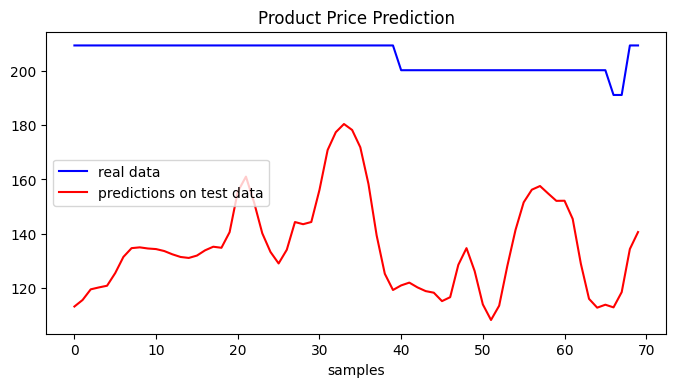

In [76]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
multivariate_results.append(metrics)

## Models Results

In [77]:
print(tabulate(multivariate_results,
               headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(multivariate_results,
         headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )


\begin{tabular}{lrrrrrr}
\toprule
 Multivariate Model   &     MAE &      MSE &    RMSE &   RMSLE &        R2 &       AR2 \\
\midrule
 Vanilla LSTM         & 22.4376 &  812.556 & 28.5054 &  3.3501 &  -31.5102 &  -35.7739 \\
 Stacked LSTM         & 18.9358 &  571.144 & 23.8986 &  3.1738 &  -21.8514 &  -24.8483 \\
 Bidirectional LSTM   & 30.5841 & 1339.49  & 36.5991 &  3.6    &  -52.5928 &  -59.6214 \\
 CNN LSTM             & 40.1356 & 1968.55  & 44.3683 &  3.7925 &  -77.7614 &  -80.1125 \\
 ConvLSTM             & 69.8488 & 5145.45  & 71.7318 &  4.2729 & -204.869  & -211.014  \\
\bottomrule
\end{tabular}


Multivariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
Vanilla LSTM,22.4376,812.556,28.5054,3.3501,-31.5102,-35.7739
Stacked LSTM,18.9358,571.144,23.8986,3.1738,-21.8514,-24.8483
Bidirectional LSTM,30.5841,1339.49,36.5991,3.6,-52.5928,-59.6214
CNN LSTM,40.1356,1968.55,44.3683,3.7925,-77.7614,-80.1125
ConvLSTM,69.8488,5145.45,71.7318,4.2729,-204.869,-211.014
